In [1]:
%matplotlib notebook
import logging
import os
import math
import multiprocessing
import json
import re
from itertools import combinations
    
from scipy.stats import t
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.rc("font", size=14)
plt.rc("axes", titlesize=14)
plt.rc("axes", labelsize=14)
plt.rc("xtick", labelsize=14)
plt.rc("ytick", labelsize=14)
plt.rc("legend", fontsize=14)
plt.rc("figure", titlesize=14)


## Grant Breaking impacts

In [ ]:
"High":{
        "3GPP": "/hdd/results-analysis/data/parsed_data/non-periodic/nonPeriodic-3GPP-03vpm-2021-02-20-17_25_24",
        "ETSI": "/hdd/results-analysis/data/parsed_data/non-periodic/nonPeriodic-ETSI-03vpm-2021-02-19-12_11_24",
        "No-GB-3GPP": "/hdd/results-analysis/data/parsed_data/non-periodic/nonPeriodic-3GPP-03vpm-noGrantBreak-2021-03-01-09_13_56",
        "No-GB-ETSI": "/hdd/results-analysis/data/parsed_data/non-periodic/nonPeriodic-ETSI-03vpm-noGrantBreak-2021-02-25-18_03_32"
    }

In [5]:
densities = { 
    "medium": {
        "3GPP": "/hdd/results-analysis/data/parsed_data/non-periodic/nonPeriodic-3GPP-012vpm-2021-02-18-17_25_27",
        "ETSI": "/hdd/results-analysis/data/parsed_data/non-periodic/nonPeriodic-ETSI-012vpm-2021-02-18-17_26_27",
        "Periodic": "/hdd/results-analysis/data/parsed_data/non-periodic/periodic-012vpm-2021-01-27-10_09_01",
        "Single-slot": "/hdd/results-analysis/data/parsed_data/non-periodic/reschedule-012vpm-2021-02-23-10_25_18",
        "No-GB-3GPP": "/hdd/results-analysis/data/parsed_data/non-periodic/nonPeriodic-3GPP-012vpm-noGrantBreak-no-sci-2021-02-17-09_19_32",
        "No-GB-ETSI": "/hdd/results-analysis/data/parsed_data/non-periodic/nonPeriodic-ETSI-012vpm-noGrantBreak-no-sci-2021-02-17-08_41_02"
    }
}

Density: medium
Config: 3GPP
AverageGrantLength: 9.950513538748833, grantLength STD: 3.153574492016449
Average grant Transmissions: 4.218300653594771, grantTransmissions STD: 3.0653662008278815
Config: ETSI
AverageGrantLength: 9.956000345095333, grantLength STD: 3.131481418257127
Average grant Transmissions: 1.0119920628073504, grantTransmissions STD: 0.23044813541539372
Config: Periodic
AverageGrantLength: 9.954995871180842, grantLength STD: 3.1475052400811183
Average grant Transmissions: 9.95829892650702, grantTransmissions STD: 3.191064952684972
Config: Single-slot
AverageGrantLength: 9.985619128949615, grantLength STD: 3.1587650067099835
Average grant Transmissions: 1.0, grantTransmissions STD: 0.0
Config: No-GB-3GPP
AverageGrantLength: 9.858910891089108, grantLength STD: 3.1580046481760387
Average grant Transmissions: 9.862623762376238, grantTransmissions STD: 3.1580046481760387
Config: No-GB-ETSI
AverageGrantLength: 9.84201388888889, grantLength STD: 3.153741336143899
Average gra

<IPython.core.display.Javascript object>


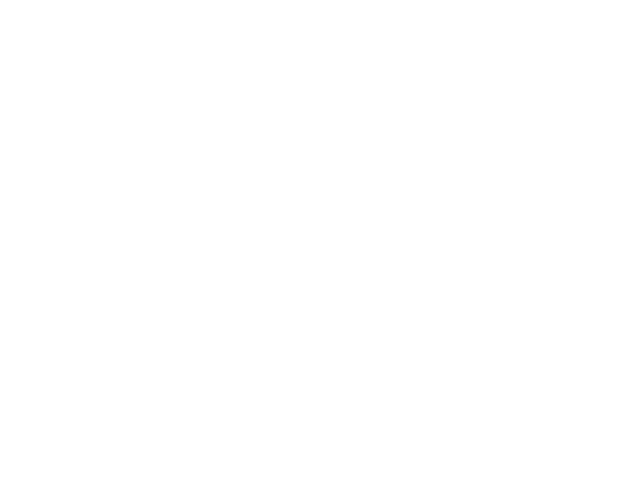

<IPython.core.display.Javascript object>


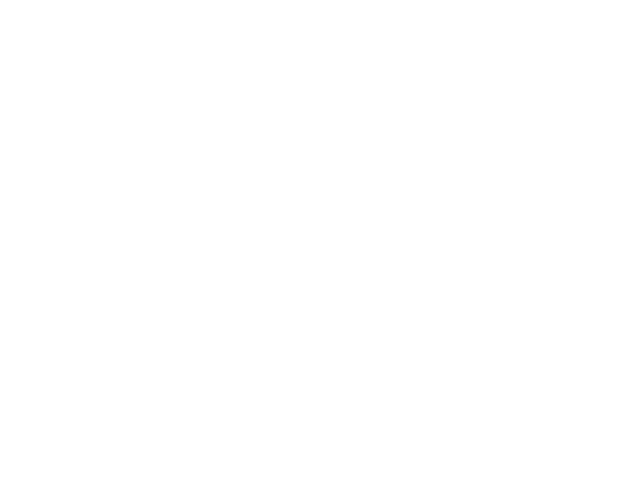

In [6]:
for density in densities:
    print("="*26)
    print("Density: {}".format(density))

    for config in densities[density]:
        print("="*26)
        print("Config: {}".format(config))
        overall_df = pd.DataFrame()
        for run_num in range(1,6):
            df = pd.read_csv("{}/run-{}.csv".format(densities[density][config], run_num))

            grant_df = df[["NodeID", "Time", "grantBreak", "grantBreakMissedTrans", 
                           "grantBreakSize", "grantBreakTiming","grantStartTime", "selectedSubchannelIndex",
                           "resourceReselectionCounter"]]

            grant_df = grant_df.dropna(subset=["grantBreak", "grantBreakMissedTrans", "grantBreakSize",
                                               "grantBreakTiming", "grantStartTime", "selectedSubchannelIndex",
                                               "resourceReselectionCounter"], how="all")

            grant_description = grant_df[grant_df["grantStartTime"].notnull()]
            grant_description = grant_description[["NodeID", "grantStartTime", 
                                                   "selectedSubchannelIndex", 
                                                   "resourceReselectionCounter"]].reset_index(drop=True)

            grant_breaking_df = grant_df[["NodeID", "Time", "grantBreak", "grantBreakMissedTrans", "grantBreakSize", "grantBreakTiming"]]
            grant_breaking_df = grant_breaking_df.dropna(subset=["grantBreak", "grantBreakMissedTrans", "grantBreakSize", "grantBreakTiming"], how="all")
            grant_breaking_df["earlyGrantBreak"] = np.where(
                (grant_breaking_df["grantBreakMissedTrans"].eq(1)) | 
                (grant_breaking_df["grantBreakSize"].eq(1)) | 
                (grant_breaking_df["grantBreakTiming"].eq(1)), 1, 0)
            grant_breaking_df["grantBreak"] = np.where(grant_breaking_df["earlyGrantBreak"].eq(1), 0, 1)
            grant_breaking_df = grant_breaking_df[["NodeID", "Time", "grantBreak", "earlyGrantBreak"]]
            grant_description = grant_description.reset_index(drop=True)

            combined_df = pd.merge(grant_description, grant_breaking_df, left_on=["NodeID"], right_on=["NodeID"], how='right')
            combined_df = combined_df[(combined_df["grantStartTime"] < combined_df["Time"])]
            combined_df = combined_df.drop_duplicates(subset=["NodeID", "grantStartTime"], keep="first")
            combined_df = combined_df.reset_index(drop=True)
            combined_df = combined_df.sort_values(by=["grantStartTime"]).reset_index(drop=True)
            combined_df = combined_df.rename(columns={"Time": "grantBreakTime"})

            if config == "Single-slot":
                combined_df["grantTransmissions"] = (
                    (combined_df["grantBreakTime"] - combined_df["grantStartTime"]) / 0.1)
                combined_df["grantTransmissions"] = np.ceil(combined_df["grantTransmissions"])
                combined_df.loc[combined_df.grantTransmissions == 2, 'grantTransmissions'] = 1
            else:
                combined_df["timeDiff"] = combined_df["grantBreakTime"] - combined_df["grantStartTime"]
                combined_df["trans2"] = combined_df["timeDiff"] / 0.1
                combined_df["trans3"] = combined_df["trans2"].round()
                combined_df["grantTransmissions"] = combined_df["trans3"].astype(int)

            combined_df["averageGrantUsage"] = (combined_df["grantTransmissions"] / combined_df["resourceReselectionCounter"]) * 100
            combined_df["averageGrantUsage"] = combined_df["averageGrantUsage"].astype(int)
            
            if overall_df.empty:
                overall_df = combined_df
            else:
                overall_df.append(combined_df)

        average_grant_transmissions = overall_df["grantTransmissions"].mean()
        average_grant_length = overall_df["resourceReselectionCounter"].mean()

        early_breaks = overall_df["earlyGrantBreak"].sum()
        total_grants = overall_df["grantStartTime"].count()


        print("AverageGrantLength: {}, grantLength STD: {}".format(average_grant_length, combined_df["resourceReselectionCounter"].std()))
        print("Average grant Transmissions: {}, grantTransmissions STD: {}".format(average_grant_transmissions, combined_df["grantTransmissions"].std()))    
    
        if config == "ETSI":            
            grants_used_wrongly_etsi = (early_breaks / total_grants) * 100
            average_grant_usage_etsi = (average_grant_transmissions/average_grant_length) * 100
            grant_ci_etsi = 1.96 * combined_df["averageGrantUsage"].std()
        elif config == "3GPP":
            grants_used_wrongly_3gpp = (early_breaks / total_grants) * 100
            average_grant_usage_3gpp = (average_grant_transmissions/average_grant_length) * 100
            grant_ci_3gpp =  1.96 * combined_df["averageGrantUsage"].std()
        elif config == "Periodic":
            grants_used_wrongly_periodic = (early_breaks / total_grants) * 100
            average_grant_usage_periodic = (average_grant_transmissions/average_grant_length) * 100
            grant_ci_periodic = 1.96 * combined_df["averageGrantUsage"].std()
        elif config == "Single-slot":
            grants_used_wrongly_single_slot = (early_breaks / total_grants) * 100
            average_grant_usage_single_slot = (average_grant_transmissions/average_grant_length) * 100
            grant_ci_single_slot = 1.96 * combined_df["averageGrantUsage"].std()
        
        
    ########################################################################################################
        
    fig, ax = plt.subplots()

    labels = ['Aperiodic\n(3GPP)', 'Aperiodic\n(ETSI)', 'Periodic\n(100ms)', 'Periodic\n(Single Slot)']
    percentages = [grants_used_wrongly_3gpp, grants_used_wrongly_etsi,
                   grants_used_wrongly_periodic, grants_used_wrongly_single_slot]

    width = 0.3  # the width of the bars

    r1 = np.arange(len(labels))

    rects1 = ax.bar(r1, percentages, width, color='none', edgecolor='green', hatch='//', lw=1., zorder = 0)

    ax.set_ylabel('Total Grants Breaks (%) ')
    ax.set_ylim(0, 100)
    plt.yticks(np.arange(0, 101, 10))
    plt.xticks([r for r in range(len(labels))], labels)
    ax.set_xticklabels(labels)

    fig.tight_layout()

    plt.savefig("../data/figures/{}-grants.eps".format(density))

    plt.close(fig)
    
    #######################################################################################################

    fig, ax = plt.subplots()

    labels = ['Aperiodic\n(3GPP)', 'Aperiodic\n(ETSI)', 'Periodic\n(100ms)', 'Periodic\n(Single Slot)']
    percentages = [average_grant_usage_3gpp, average_grant_usage_etsi,
                   average_grant_usage_periodic, average_grant_usage_single_slot]
    yerror = [grant_ci_3gpp, grant_ci_etsi, grant_ci_periodic, grant_ci_single_slot]
    
    upper = []
    lower = []
    new_yerrors = []
    for mean, err in zip(percentages, yerror):
        top = err
        bottom = err
        if mean - err < 6:
            bottom = mean - 6
        if mean + err > 100:
            top = 100 - mean
        upper.append(top)
        lower.append(bottom)

    new_yerrors.append(lower)
    new_yerrors.append(upper)
    
    new_yerrors[0][2] = 0
    new_yerrors[1][2] = 0

    width = 0.3  # the width of the bars

    r1 = np.arange(len(labels))

    rects1 = ax.bar(r1, percentages, width, yerr=new_yerrors, capsize=10, color='none', fill=False, edgecolor='green', hatch='//', lw=1., zorder = 0, alpha=1)

    ax.set_ylabel('Average grant usage (%) ')
    ax.set_ylim(0, 100)
    plt.yticks(np.arange(0, 101, 10))
    plt.xticks([r for r in range(len(labels))], labels)
    ax.set_xticklabels(labels)

    fig.tight_layout()

#     plt.show()

    plt.savefig("../data/figures/{}-Grant-Usage.eps".format(density))

    plt.close(fig)

### Unused Resources Graph

In [7]:
results= {}
for density in densities:
    print("="*26)
    print("Density: {}".format(density))
    
    results[density] = {}

    for config in densities[density]:
        print("="*26)
        print("Config: {}".format(config))
        
        results[density][config] = {}
        over_all_booked_free = 0 
        over_all_total = 0
        over_all_free = 0
        over_all_correct_use = 0
        
        for run_num in range(1, 2):
            
            df = pd.read_csv("{}/run-{}.csv".format(densities[density][config], run_num))
            
            df = df[df["Time"] > 502]
            
            if "Single-slot" in config:
                grant_df = df[["NodeID", "Time", "grantBreak", "grantBreakMissedTrans", 
                               "grantBreakSize", "grantBreakTiming","grantStartTime", "selectedSubchannelIndex",
                               "resourceReselectionCounter", "posX", "posY"]]

                grant_df = grant_df.dropna(subset=["grantBreak", "grantBreakMissedTrans", "grantBreakSize",
                                                   "grantBreakTiming", "grantStartTime", "selectedSubchannelIndex",
                                                   "resourceReselectionCounter"], how="all")

                grant_description = grant_df[grant_df["grantStartTime"].notnull()]
                grant_description = grant_description[["NodeID", "grantStartTime", 
                                                       "selectedSubchannelIndex", 
                                                       "resourceReselectionCounter"]].reset_index(drop=True)

                grant_breaking_df = grant_df[["NodeID", "Time", "grantBreak", "grantBreakMissedTrans", "grantBreakSize", "grantBreakTiming"]]
                grant_breaking_df = grant_breaking_df.dropna(subset=["grantBreak", "grantBreakMissedTrans", "grantBreakSize", "grantBreakTiming"], how="all")
                grant_breaking_df["earlyGrantBreak"] = np.where(
                    (grant_breaking_df["grantBreakMissedTrans"].eq(1)) | 
                    (grant_breaking_df["grantBreakSize"].eq(1)) | 
                    (grant_breaking_df["grantBreakTiming"].eq(1)), 1, 0)
                grant_breaking_df["grantBreak"] = np.where(grant_breaking_df["earlyGrantBreak"].eq(1), 0, 1)
                grant_breaking_df = grant_breaking_df[["NodeID", "Time", "grantBreak", "earlyGrantBreak"]]
                grant_description = grant_description.reset_index(drop=True)

                combined_df = pd.merge(grant_description, grant_breaking_df, left_on=["NodeID"], right_on=["NodeID"], how='right')
                combined_df = combined_df[(combined_df["grantStartTime"] < combined_df["Time"])]
                combined_df = combined_df.drop_duplicates(subset=["NodeID", "grantStartTime"], keep="first")
                combined_df = combined_df.reset_index(drop=True)
                combined_df = combined_df.sort_values(by=["grantStartTime"]).reset_index(drop=True)
                combined_df = combined_df.rename(columns={"Time": "grantBreakTime"})
                
                combined_df["grantTransmissions"] = (
                    (combined_df["grantBreakTime"] - combined_df["grantStartTime"]) / 0.1)
                combined_df["grantTransmissions"] = np.ceil(combined_df["grantTransmissions"])
                combined_df.loc[combined_df.grantTransmissions == 2, 'grantTransmissions'] = 1

                subchannel_number = grant_description["selectedSubchannelIndex"].max() + 1
                min_time = grant_description["grantStartTime"].min()
                max_time = grant_description["grantStartTime"].max()

                all_possible_times = np.arange(min_time, max_time, 0.001)
                num_subchannels = len(all_possible_times) * subchannel_number

                combined_df["averageGrantUsage"] = (combined_df["grantTransmissions"] / combined_df["resourceReselectionCounter"]) * 100
                combined_df["averageGrantUsage"] = combined_df["averageGrantUsage"].astype(int)

                average_grant_transmissions = combined_df["grantTransmissions"].mean()
                average_grant_length = combined_df["resourceReselectionCounter"].mean()
                early_breaks = combined_df["earlyGrantBreak"].sum()
                total_grants = combined_df["grantStartTime"].count()
                
                sending_df = combined_df[["grantStartTime", "selectedSubchannelIndex"]]
                broken_df = combined_df[["grantStartTime", "selectedSubchannelIndex"]]
                broken_df["UnusedTime"] = broken_df["grantStartTime"] + 0.1
                broken_df = broken_df[["UnusedTime", "selectedSubchannelIndex"]]

                sending_df["Time"] = round(sending_df["grantStartTime"], 3)
                broken_df["Time"] = round(broken_df["UnusedTime"], 3)

                sending_df = sending_df[["Time", "selectedSubchannelIndex"]]
                broken_df = broken_df[["Time", "selectedSubchannelIndex"]]

                together = pd.merge(sending_df, broken_df, on=["Time", "selectedSubchannelIndex"], how="inner")
                together["Time"] = round(together["Time"], 3)

                together.reset_index(inplace=True, drop=True)
                sending_df.reset_index(inplace=True, drop=True)
                broken_df.reset_index(inplace=True, drop=True)

                sending_df = sending_df.loc[pd.merge(sending_df, together, on=['Time','selectedSubchannelIndex'], how='left', indicator=True)['_merge'] == 'left_only']
                broken_df = broken_df.loc[pd.merge(broken_df, together, on=['Time','selectedSubchannelIndex'], how='left', indicator=True)['_merge'] == 'left_only']

                together_collisions = together.pivot_table(index=['Time','selectedSubchannelIndex'], aggfunc='size')
                count_sends = sending_df.pivot_table(index=['Time','selectedSubchannelIndex'], aggfunc='size')
                count_missed = broken_df.pivot_table(index=['Time','selectedSubchannelIndex'], aggfunc='size')

                duplicates_together = together_collisions[together_collisions > 1]
                duplicates_sends = count_sends[count_sends > 1]
                duplicates_missed = count_missed[count_missed > 1]

                reserved_occupied_count = duplicates_together.count()
                occupied_occupied_count = duplicates_sends.count()
                reserved_reserved_count = duplicates_missed.count()

                together = together.drop_duplicates()
                sending_df = sending_df.drop_duplicates()
                broken_df = broken_df.drop_duplicates()

                booked_free = broken_df.shape[0] + together.shape[0]

                total = 1000 * 10 * 3

                correct_use = sending_df.shape[0]

                free = total - correct_use - booked_free
                
                over_all_booked_free += booked_free
                over_all_correct_use += correct_use
                over_all_free += free
                over_all_total += total

            else:
                # Get grant information
                grant_df = df[["NodeID", "grantStartTime", "selectedSubchannelIndex"]]
                grant_df = grant_df.dropna()
                grant_df = grant_df.groupby(
                    'NodeID', group_keys=False
                ).apply(lambda d: d.iloc[:-1].assign(grantEndTime=d.grantStartTime.values[1:]))
                grant_df = grant_df[["NodeID", "grantStartTime", "grantEndTime", "selectedSubchannelIndex"]]

                # Get missed Transmission information
                missed_df = df[["NodeID", "Time", "missedTransmission"]]
                missed_df = missed_df.dropna()

                # Get sent information
                sent_df = df[["NodeID", "Time", "sciSent", "tbSent", "subchannelSent"]]
                sent_df = sent_df.dropna()

                # Combine grant information with missed transmission information such that a new subchannel missed column
                # is created which highlights the subchannel which should have been used.
                combined_df = pd.merge(grant_df, missed_df, on=["NodeID"], how="inner")

                # Grant must be first
                combined_df = combined_df[(combined_df["grantStartTime"] < combined_df["Time"]) & 
                                          (combined_df["grantEndTime"] > combined_df["Time"])]

                # Find those resources which were missed transmissions
                missed_sent_df = pd.merge(sent_df, combined_df, left_on=["Time", "subchannelSent"], 
                                          right_on = ["Time", "selectedSubchannelIndex"])

                missed_sent_df = missed_sent_df.rename(columns={'NodeID_x': 'NodeID'})

                together = pd.merge(combined_df, sent_df, left_on=["Time", "selectedSubchannelIndex"], 
                                    right_on=["Time", "subchannelSent"], how="inner")

                together_sent = together[["NodeID_x", "Time", "sciSent", "tbSent", "subchannelSent"]]
                together_sent = together_sent.rename(columns={"NodeID_x": "NodeID"})

                temp_sent_df = pd.merge(sent_df, together_sent, on=['Time','subchannelSent'], how='left', indicator=True)
                correct_trans = temp_sent_df.loc[temp_sent_df['_merge'] == 'left_only']

                temp_missed_df = pd.merge(combined_df, together, on=['Time','selectedSubchannelIndex'], how='left', indicator=True)
                missed_trans = temp_missed_df.loc[temp_missed_df['_merge'] == 'left_only']

                together_collisions = together.pivot_table(index=['Time','subchannelSent'], aggfunc='size')
                count_sends = correct_trans.pivot_table(index=['Time','subchannelSent'], aggfunc='size')
                count_missed = missed_trans.pivot_table(index=['Time','subchannelSent'], aggfunc='size')

                duplicates_together = together_collisions[together_collisions > 1]
                duplicates_sends = count_sends[count_sends > 1]
                duplicates_missed = count_missed[count_missed > 1]

                reserved_occupied_count = duplicates_together.count()
                occupied_occupied_count = duplicates_sends.count()
                reserved_reserved_count = duplicates_missed.count()

                together = together.drop_duplicates()
                correct_trans = correct_trans.drop_duplicates()
                missed_trans = missed_trans.drop_duplicates()

                booked_free = missed_trans.shape[0] + together.shape[0]

                correct_use = correct_trans.shape[0]

                total = 1000 * 12 * 3

                free = total - correct_use - booked_free

                over_all_booked_free += booked_free
                over_all_correct_use += correct_use
                over_all_free += free
                over_all_total += total
            
        results[density][config]["booked_free"] = over_all_booked_free
        results[density][config]["correct_use"] = over_all_correct_use
        results[density][config]["free"] = over_all_free
        results[density][config]["total"] = over_all_total
        

Density: medium
Config: 3GPP
Config: ETSI
Config: Periodic
Config: Single-slot


<ipython-input-7-a941ec91f77c>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  broken_df["UnusedTime"] = broken_df["grantStartTime"] + 0.1
<ipython-input-7-a941ec91f77c>:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sending_df["Time"] = round(sending_df["grantStartTime"], 3)


Config: No-GB-3GPP
Config: No-GB-ETSI


In [8]:
density = "medium"

##############################################################################################################
config = "3GPP"
booked_but_free_3gpp = (results[density][config]["booked_free"]/results[density][config]["total"]) * 100
used_3gpp = (results[density][config]["correct_use"]/results[density][config]["total"]) * 100
unused_3gpp = (results[density][config]["free"]/results[density][config]["total"]) * 100 

##############################################################################################################
config = "ETSI"
booked_but_free_etsi = (results[density][config]["booked_free"]/results[density][config]["total"]) * 100
used_etsi = (results[density][config]["correct_use"]/results[density][config]["total"]) * 100
unused_etsi = (results[density][config]["free"]/results[density][config]["total"]) * 100 

##############################################################################################################
config = "Periodic"
booked_but_free_periodic = (results[density][config]["booked_free"]/results[density][config]["total"]) * 100
used_periodic = (results[density][config]["correct_use"]/results[density][config]["total"]) * 100
unused_periodic = (results[density][config]["free"]/results[density][config]["total"]) * 100 

##############################################################################################################
config = "Single-slot"
booked_but_free_single_slot = (results[density][config]["booked_free"]/results[density][config]["total"]) * 100
used_single_slot = (results[density][config]["correct_use"]/results[density][config]["total"]) * 100
unused_single_slot = (results[density][config]["free"]/results[density][config]["total"]) * 100 

##############################################################################################################
config = "No-GB-3GPP"
booked_but_free_3gppNoGB = (results[density][config]["booked_free"]/results[density][config]["total"]) * 100
used_3gppNoGB = (results[density][config]["correct_use"]/results[density][config]["total"]) * 100
unused_3gppNoGB = (results[density][config]["free"]/results[density][config]["total"]) * 100 

##############################################################################################################
config = "No-GB-ETSI"
booked_but_free_etsiNoGB = (results[density][config]["booked_free"]/results[density][config]["total"]) * 100
used_etsiNoGB = (results[density][config]["correct_use"]/results[density][config]["total"]) * 100
unused_etsiNoGB = (results[density][config]["free"]/results[density][config]["total"]) * 100 

In [9]:
print("="*40)
print("3GPP:")
print("Booked but free: {}%".format(booked_but_free_3gpp))
print("Used: {}%".format(used_3gpp))
print("Unused: {}%".format(unused_3gpp))

#############################################################
print("="*40)
print("ETSI:")
print("Booked but free: {}%".format(booked_but_free_etsi))
print("Used: {}%".format(used_etsi))
print("Unused: {}%".format(unused_etsi))

#############################################################
print("="*40)
print("3GPP No GB:")
print("Booked but free: {}%".format(booked_but_free_3gppNoGB))
print("Used: {}%".format(used_3gppNoGB))
print("Unused: {}%".format(unused_3gppNoGB))

#############################################################
print("="*40)
print("ETSI No GB:")
print("Booked but free: {}%".format(booked_but_free_etsiNoGB))
print("Used: {}%".format(used_etsiNoGB))
print("Unused: {}%".format(unused_etsiNoGB))

#############################################################
print("="*40)
print("Periodic:")
print("Booked but free: {}%".format(booked_but_free_periodic))
print("Used: {}%".format(used_periodic))
print("Unused: {}%".format(unused_periodic))

# #############################################################
print("="*40)
print("Single Slot:")
print("Booked but free: {}%".format(booked_but_free_single_slot))
print("Used: {}%".format(used_single_slot))
print("Unused: {}%".format(unused_single_slot))

3GPP:
Booked but free: 11.563888888888888%
Used: 52.03055555555556%
Unused: 36.40555555555556%
ETSI:
Booked but free: 27.18333333333333%
Used: 23.97222222222222%
Unused: 48.84444444444445%
3GPP No GB:
Booked but free: 10.994444444444444%
Used: 50.955555555555556%
Unused: 38.05%
ETSI No GB:
Booked but free: 31.730555555555558%
Used: 21.57777777777778%
Unused: 46.69166666666666%
Periodic:
Booked but free: 0.0%
Used: 68.25277777777778%
Unused: 31.74722222222222%
Single Slot:
Booked but free: 43.64666666666667%
Used: 27.71666666666667%
Unused: 28.636666666666667%


In [10]:
plt.ioff()

fig, ax = plt.subplots()

labels = [
    'Aperiodic\n(3GPP)', 'Aperiodic\n(ETSI)',
    'Periodic\n(100ms)', 'Periodic\n(Single Slot)'
]
booked_but_free = [
    booked_but_free_3gpp, booked_but_free_etsi,
    booked_but_free_periodic, booked_but_free_single_slot]
used = [
    used_3gpp, used_etsi,
    used_periodic, used_single_slot
]
unused = [
    unused_3gpp, unused_etsi,
    unused_periodic, unused_single_slot
]

width = .2  # the width of the bars

r1 = np.arange(len(labels))
r2 = [x + width for x in r1] 
r3 = [x + width for x in r2]

patterns = ['-', '+', 'x', '\\', '*', 'o', 'O', '.']
rects1 = ax.bar(r1, booked_but_free, width, label='Reserved but unused', color='none', edgecolor='green', hatch='//', lw=1., zorder = 0)
rects2 = ax.bar(r2, used, width, label='Occupied', color='none', edgecolor='black', hatch='xx', lw=1., zorder = 0)
rects3 = ax.bar(r3, unused, width, label='Free', align="center", edgecolor='black', fill=None, lw=1., zorder = 0)
ax.set_ylabel('Resources Occupancy %')
plt.xticks([r + width for r in range(len(labels))], labels)
ax.set_xticklabels(labels)
ax.legend(prop={'size': 10})
ax.set_ylim(0, 100)
plt.yticks(np.arange(0, 101, 10))

fig.tight_layout()

plt.savefig("../data/figures/medium-resources.eps".format(density))

plt.close(fig)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [12]:
plt.rc("font", size=14)
plt.rc("axes", titlesize=14)
plt.rc("axes", labelsize=14)
plt.rc("xtick", labelsize=12)
plt.rc("ytick", labelsize=14)
plt.rc("legend", fontsize=14)
plt.rc("figure", titlesize=14)

plt.ioff()

fig, ax = plt.subplots()

labels = [
    'Aperiodic\n(3GPP)', 'Aperiodic\n(ETSI)',
    'Aperiodic\n No GB\n (3GPP)', 'Aperiodic\n No GB\n (ETSI)',
    'Periodic\n(100ms)', 'Periodic\n(Single Slot)'
]
booked_but_free = [
    booked_but_free_3gpp, booked_but_free_etsi,
    booked_but_free_3gppNoGB, booked_but_free_etsiNoGB,
    booked_but_free_periodic, booked_but_free_single_slot
]
used = [
    used_3gpp, used_etsi,
    used_3gppNoGB, used_etsiNoGB,
    used_periodic, used_single_slot
]
unused = [
    unused_3gpp, unused_etsi,
    unused_3gppNoGB, unused_etsiNoGB,
    unused_periodic, unused_single_slot
]

width = .2  # the width of the bars

r1 = np.arange(len(labels))
r2 = [x + width for x in r1] 
r3 = [x + width for x in r2]

patterns = ['-', '+', 'x', '\\', '*', 'o', 'O', '.']
rects1 = ax.bar(r1, booked_but_free, width, label='Reserved but unused', color='none', edgecolor='green', hatch='//', lw=1., zorder = 0)
rects2 = ax.bar(r2, used, width, label='Occupied', color='none', edgecolor='black', hatch='xx', lw=1., zorder = 0)
rects3 = ax.bar(r3, unused, width, label='Free', align="center", edgecolor='black', fill=None, lw=1., zorder = 0)
ax.set_ylabel('Resources Occupancy %')
plt.xticks([r + width for r in range(len(labels))], labels)
ax.set_xticklabels(labels)
ax.legend(prop={'size': 10})
ax.set_ylim(0, 100)
plt.yticks(np.arange(0, 101, 10))

fig.tight_layout()

plt.savefig("../data/figures/noGB-resource-occupancy.eps".format(density))

plt.close(fig)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


### CBR Across Configurations and Densities

In [16]:
cbr_configs = {
    "Periodic" : [
        "/hdd/results-analysis/data/processed_data/non-periodic-no-sci/periodic-006vpm-2021-01-27-10_09_01",
        "/hdd/results-analysis/data/processed_data/non-periodic-no-sci/periodic-012vpm-2021-01-27-10_09_01",
        "/hdd/results-analysis/data/processed_data/non-periodic-no-sci/periodic-02vpm-2021-01-27-10_09_01",
        "/hdd/results-analysis/data/processed_data/non-periodic-no-sci/periodic-03vpm-2020-11-18-10_54_58"
    ],
    "3GPP": [
        "/hdd/results-analysis/data/processed_data/non-periodic-no-sci/nonPeriodic-3GPP-006vpm-2021-02-19-10_12_41",
        "/hdd/results-analysis/data/processed_data/non-periodic-no-sci/nonPeriodic-3GPP-012vpm-2021-02-18-17_25_27",
        "/hdd/results-analysis/data/processed_data/non-periodic-no-sci/nonPeriodic-3GPP-02vpm-2021-02-19-10_32_49",
        "/hdd/results-analysis/data/processed_data/non-periodic-no-sci/nonPeriodic-3GPP-03vpm-2021-02-20-17_25_24"
    ],
    "ETSI": [
        "/hdd/results-analysis/data/processed_data/non-periodic-no-sci/nonPeriodic-ETSI-006vpm-2021-02-19-10_12_41",
        "/hdd/results-analysis/data/processed_data/non-periodic-no-sci/nonPeriodic-ETSI-012vpm-2021-02-18-17_26_27",
        "/hdd/results-analysis/data/processed_data/non-periodic-no-sci/nonPeriodic-ETSI-02vpm-2021-02-19-10_22_59",
        "/hdd/results-analysis/data/processed_data/non-periodic-no-sci/nonPeriodic-ETSI-03vpm-2021-02-19-12_11_24"
    ],
    "Single-slot": [
        "/hdd/results-analysis/data/processed_data/non-periodic-no-sci/reschedule-006vpm-2021-01-27-10_09_01",
        "/hdd/results-analysis/data/processed_data/non-periodic-no-sci/reschedule-012vpm-2020-11-18-12_20_24",
        "/hdd/results-analysis/data/processed_data/non-periodic-no-sci/reschedule-02vpm-2020-11-18-10_54_58",
        "/hdd/results-analysis/data/processed_data/non-periodic-no-sci/reschedule-03vpm-2020-11-18-10_54_58"
    ],
    "No-GB-3GPP": [
        "/hdd/results-analysis/data/processed_data/non-periodic-no-sci/nonPeriodic-3GPP-012vpm-noGrantBreak-no-sci-2021-02-17-09_19_32"
        
    ],
    "No-GB-ETSI": [
        "/hdd/results-analysis/data/processed_data/non-periodic-no-sci/nonPeriodic-ETI-012vpm-noGrantBreak-no-sci-2021-02-17-11_03_02"
    ]
}

In [17]:
for config in cbr_configs:
    print("="*30)
    print(config)
    print("="*30)
    for density in cbr_configs[config]:
        df = pd.read_csv("{}/CBR.csv".format(density))
        avg_cbr = df["Mean"].mean() * 100
        if "006vpm" in density:
            print("006vpm: {}%".format(avg_cbr))
        elif "012vpm" in density:
            print("012vpm: {}%".format(avg_cbr))
        elif "02vpm" in density:
            print("02vpm: {}%".format(avg_cbr))
        else:
            print("03vpm: {}%".format(avg_cbr))

Periodic
006vpm: 26.471794092614363%
012vpm: 44.62948183452991%
02vpm: 67.57032058735645%
03vpm: 83.09797135424836%
3GPP
006vpm: 21.46395583071492%
012vpm: 37.55094068693726%
02vpm: 58.563475964330124%
03vpm: 72.14849279554836%
ETSI
006vpm: 19.655251012477333%
012vpm: 16.907800674946838%
02vpm: 18.493223765686043%
03vpm: 15.754956555329258%
Single-slot
006vpm: 21.74135276659175%
012vpm: 36.424658874090795%
02vpm: 49.15865011386627%
03vpm: 55.81674631699375%
No-GB-3GPP
012vpm: 37.46754340869243%
No-GB-ETSI
012vpm: 19.431295353405208%
